In [2]:
%pylab inline
import os
import gc
import galsim
import numpy as np
from fpfs import fpfsBase
import astropy.io.fits as pyfits
pltDir='plot/demo'

Populating the interactive namespace from numpy and matplotlib


In [3]:
cd wrkDir/FPFS2/sim2

/lustre/work/xiangchong.li/work/FPFS2/sim2


In [14]:
ifield      =   2
ngrid       =   64
nx          =   1
ny          =   1
ndata       =   nx*ny
nrot        =   4
scale       =   0.168
bigfft      =   galsim.GSParams(maximum_fft_size=10240)
flux_scaling=   2.587

variance    =   0.0035
ud          =   galsim.UniformDeviate(ifield*10000+1)
np.random.seed(ifield*10000+1)

# training data
catName     =   'real_galaxy_catalog_25.2.fits'
directory   =   os.path.join(os.environ['homeWrk'],'COSMOS/galsim_train/COSMOS_25.2_training_sample/')

cosmos_cat  =   galsim.COSMOSCatalog(catName, dir=directory)

# index
index_use   =   cosmos_cat.orig_index
# parametric catalog
param_cat   =   cosmos_cat.param_cat[index_use]
ngAll       =   len(index_use)

# Get the psf
if True:
    psfFname    =   os.path.join('psfPre','psf%04d.fits'%(ifield))
    psfImg      =   galsim.fits.read(psfFname)
    psfInt      =   galsim.InterpolatedImage(psfImg,scale=scale,flux = 1.)
else:
    psfInt=galsim.Moffat(beta=3.5,fwhm=0.615,trunc=0.615*4.)
    psfInt=psfInt.shear(e1=0.,e2=0.02)
    psfImg   =   psfInt.drawImage(nx=45,ny=45,scale=scale)


outFname1   =   'gal%04d-00.fits' %(ifield)
outFname2   =   'gal%04d-20.fits' %(ifield)
gal_image1  =   galsim.ImageF(nx*ngrid,ny*ngrid,scale=scale)
gal_image1.setOrigin(0,0)
gal_image2  =   galsim.ImageF(nx*ngrid,ny*ngrid,scale=scale)
gal_image2.setOrigin(0,0)

data_rows   =   []
i           =   0
while i <ndata:
    # Prepare the subimage
    ix      =   i%nx
    iy      =   i//nx
    b       =   galsim.BoundsI(ix*ngrid,(ix+1)*ngrid-1,iy*ngrid,(iy+1)*ngrid-1)
    sub_image1 = gal_image1[b]
    sub_image2 = gal_image2[b]
    #simulate the galaxy
    if i%nrot==0:
        # update galaxy
        index   =   150#np.random.randint(0,ngAll)
        ss      =   param_cat[index]
        if ss['use_bulgefit']:
            bparams = ss['bulgefit']
            gal_q   = bparams[3]
            gal_beta= bparams[7]*galsim.radians
            hlr     = ss['hlr'][2]
        else:
            sparams =   ss['sersicfit']
            gal_q   =   sparams[3]
            gal_beta=   sparams[7]*galsim.radians
            hlr     =   ss['hlr'][0]

        fluxhsc =   10**((27-ss['mag_auto'])/2.5)
        # prepare the galaxies
        gal0    =   cosmos_cat.makeGalaxy(gal_type='parametric',index=index,gsparams=bigfft)
        gal0    *=  flux_scaling

        npoints =   int(ud()*10+5)
        gal_not0=   galsim.RandomKnots(half_light_radius=min(hlr+0.1,0.8),npoints=npoints,flux=fluxhsc/100.*npoints)
        gal_not0=   gal_not0.shear(q=gal_q,beta=gal_beta)
        gal0    =   (gal0+gal_not0)/(1+npoints/100.)
        gal0    =   gal0.dilate(1+(ud()-0.5)*0.1)
        #gal0    =   gal_not0

        # rotate the galaxy
        ang     =   ud()*2.*np.pi * galsim.radians
        gal0    =   gal0.rotate(ang)
    else:
        gal0    =   gal0.rotate(1./nrot*np.pi*galsim.radians)
    print(gal0.getGoodImageSize(scale))
    gal1        =   gal0.shear(g1=-0.02,g2=0.)
    final1      =   galsim.Convolve([psfInt,gal1],gsparams=bigfft)
    final1.drawImage(sub_image1)
    gal2         =   gal0.shear(g1=0.02,g2=0.)
    final2       =   galsim.Convolve([psfInt,gal2],gsparams=bigfft)
    final2.drawImage(sub_image2)
    row=(i,index,ss['IDENT'],ss['mag_auto'],ss['zphot'])
    data_rows.append(row)
    i   +=  1
    gc.collect
#pyfits.writeto(outFname1,gal_image1.array,overwrite=True)
#pyfits.writeto(outFname2,gal_image2.array,overwrite=True)
#del gal_image1,gal_image2
#gc.collect()

48


In [17]:
np.min([1,2,3,4])

1

In [5]:
psfData=np.pad(psfImg.array,(10,9))
print(psfData.shape)
powModel=np.zeros((1,ngrid,ngrid))
powModel[0]=np.ones((ngrid,ngrid))
fpTask=fpfsBase.fpfsTask(psfData)
image_list=np.stack(np.vsplit(gal_image2.array,ny))
#a=fpTask.measure(image_list)

(62, 62)


In [6]:
image_list.shape

(2, 64, 64)

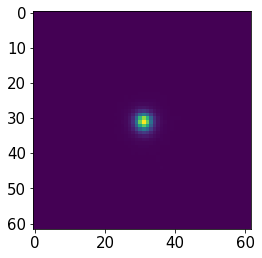

In [9]:
imshow(psfData)

In [10]:
psfData[32,32]

0.03484406080537212

In [19]:
image_list=np.vsplit(gal_image1.array,ny)
a=fpTask.measure(image_list)
b=fpfsBase.fpfsM2E(a,C)
ga1=-np.average(b['fpfs_e1'])/np.average(b['fpfs_RE'])

In [20]:
C=10
b=fpfsBase.fpfsM2E(a,C)
gb1=-np.average(b['fpfs_e1'])/np.average(b['fpfs_RE'])
print(gb1)
print(gb1/0.02-1)

0.3655369498439971
17.276847492199856


In [15]:
(gb1-ga1)/0.04-1.

-1.0

In [7]:
ngrid       =   32
nx          =   1
ny          =   1
ndata       =   nx*ny
nrot        =   4
scale       =   0.168
bigfft      =   galsim.GSParams(maximum_fft_size=10240)
flux_scaling=   2.587

variance    =   0.0035
ud          =   galsim.UniformDeviate(1)
np.random.seed(1)

# training data
catName     =   'real_galaxy_catalog_25.2.fits'
directory   =   os.path.join(os.environ['homeWrk'],'COSMOS/galsim_train/COSMOS_25.2_training_sample/')

# Get the psf
psfFname    =   os.path.join('psfPre','psf%04d.fits'%(2))
psfImg      =   galsim.fits.read(psfFname)
psfInt      =   galsim.InterpolatedImage(psfImg,scale=scale,flux = 1.)

#simulate the galaxy
gal0    =   galsim.Sersic(n=1.,half_light_radius=0.3,trunc=3,flux=0.1)
gal0    =   gal0.shear(g1=0.14,g2=0.2)
gal0b   =   gal0.shift(0.3,0.8)
gal1b   =   galsim.Sersic(n=1.1,half_light_radius=0.2,trunc=3,flux=0.08)
gal1b   =   gal1b.shear(g1=-0.1,g2=0.13).shift(-0.3,-0.8)
final1  =   gal0
final2  =   galsim.Convolve([psfInt,gal0],gsparams=bigfft)
final2b =   galsim.Convolve([psfInt,(gal0b+gal1b)],gsparams=bigfft)
gal_image1  =   galsim.ImageF(nx*ngrid*8,ny*ngrid*8,scale=scale/8.)
final1.drawImage(gal_image1,method='real_space')
gal_image2  =   galsim.ImageF(nx*ngrid,ny*ngrid,scale=scale)
final2.drawImage(gal_image2)
gal_image2b  =   galsim.ImageF(nx*ngrid,ny*ngrid,scale=scale)
final2b.drawImage(gal_image2b)
del gal0,final1,final2
gc.collect

<function gc.collect(generation=2)>

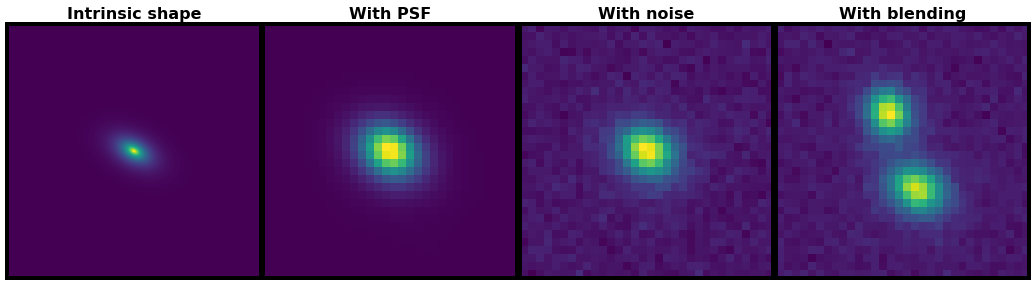

In [8]:
plt.close()
cc='black'
fs=16
figure=plt.figure(figsize=(16,4))
ax=figure.add_subplot(1,4,1)
ax.set_title(r'Intrinsic shape',fontsize=fs,weight='bold')
ax.imshow(gal_image1.array)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for pos in ['top','right','left','bottom']:
    sp=ax.spines[pos]
    sp.set_color(cc)
    sp.set_linewidth(4)

ax=figure.add_subplot(1,4,2)
ax.set_title(r'With PSF',fontsize=fs,weight='bold')
ax.imshow(gal_image2.array)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for pos in ['top','right','left','bottom']:
    sp=ax.spines[pos]
    sp.set_color(cc)
    sp.set_linewidth(4)
    
vn          =   galsim.GaussianNoise(ud,6e-5)
gal_image2.addNoise(vn)
ax=figure.add_subplot(1,4,3)
ax.set_title(r'With noise',fontsize=fs,weight='bold')
ax.imshow(gal_image2.array)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for pos in ['top','right','left','bottom']:
    sp=ax.spines[pos]
    sp.set_color(cc)
    sp.set_linewidth(4)

gal_image2b.addNoise(vn)
ax=figure.add_subplot(1,4,4)
ax.set_title(r'With blending',fontsize=fs,weight='bold')
ax.imshow(gal_image2b.array)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for pos in ['top','right','left','bottom']:
    sp=ax.spines[pos]
    sp.set_color(cc)
    sp.set_linewidth(4)

figure.subplots_adjust(left=0.02,
                bottom=0.02, 
                right=0.98, 
                top=0.90, 
                wspace=-0.24)
figure.savefig(os.path.join(pltDir,'shearEstSystematics.png'))

## PSF

In [6]:
# PSF
scale=0.168
for psfFWHM in [0.60,1.05]:
    fname='galaxy_cosmoR_psf%d/psf-%d.fits' %(psfFWHM*100,psfFWHM*100)
    if not os.path.isfile(fname):
        psfInt  =   galsim.Moffat(beta=3.5,fwhm=psfFWHM,trunc=psfFWHM*4.)
        psfInt  =   psfInt.shear(e1=0.02,e2=-0.02)
        psfImg  =   psfInt.drawImage(nx=45,ny=45,scale=scale)
        psfImg.write(fname)